<a href="https://colab.research.google.com/github/sakshi5111/Kaiburr_task6/blob/main/task6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

df = pd.read_csv('/content/drive/MyDrive/complaints.csv')
df.shape

<ipython-input-2-3d1626c58b89>:22: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/complaints.csv')


(4096581, 18)

In [ ]:
#Exploratory Data Analysis (EDA) and Feature Engineering#
df.head(2).T # Columns are shown in rows for easy reading


,0,1
Date received,2023-08-24,2023-08-25
Product,"Credit reporting, credit repair services, or o...",Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Problem with a credit reporting company's inve...,Improper use of your report
Sub-issue,Was not notified of investigation status or re...,Reporting company used your report improperly
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,Experian Information Solutions Inc.,"SANTANDER HOLDINGS USA, INC."
State,NJ,FL
ZIP code,07024,33972


In [ ]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1483946, 2)

In [ ]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [ ]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [ ]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [ ]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [ ]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Vehicle loan or lease
3,Checking or savings account
4,"Payday loan, title loan, or personal loan"
5,Bank account or service
6,Mortgage
7,Credit card or prepaid card
8,"Money transfer, virtual currency, or money ser..."
9,Consumer Loan


In [ ]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
2702748,"Credit reporting, repair, or other",Being downloaded is a Debt Validation Letter t...,0
1583134,Debt collection,I called IQ Data international on XX/XX/2019 t...,1
3307655,Vehicle loan or lease,"Hello, I have an auto load with GM Financial. ...",2
1089593,Checking or savings account,My chase bank account had over {$190000.00} do...,3
1785952,"Credit reporting, repair, or other","The consumer has not consented, authorized or ...",0


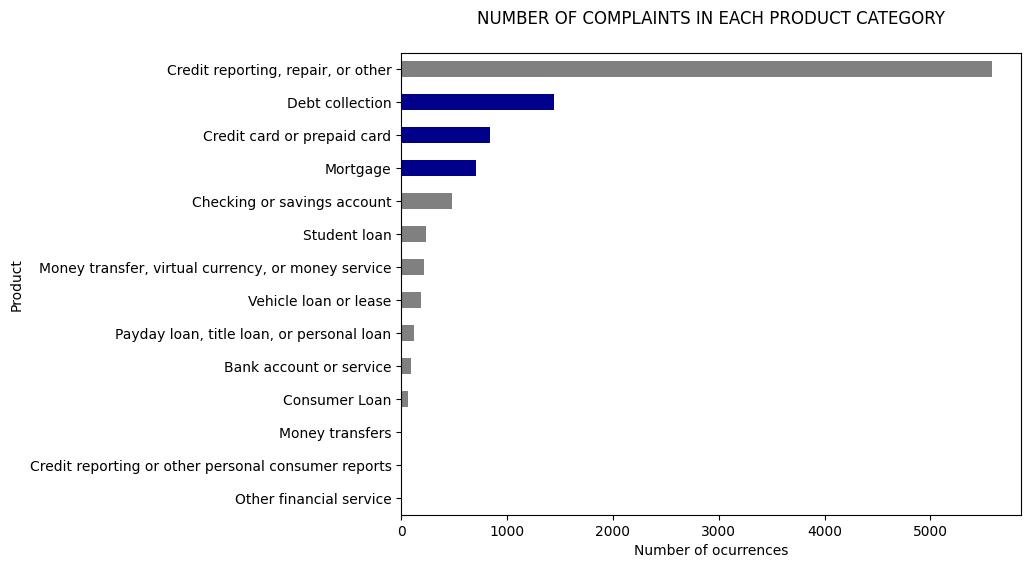

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26205 features (TF-IDF score of unigrams and bigrams)


In [ ]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    tfidf_feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in tfidf_feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in tfidf_feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))



==> Bank account or service:
  * Most Correlated Unigrams are: nsf, bank, overdraft
  * Most Correlated Bigrams are: promotion code, overdraft fee, overdraft fees

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, bank, deposit
  * Most Correlated Bigrams are: savings account, debit card, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: car, honda, tower
  * Most Correlated Bigrams are: make loan, took car, tower loan

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: synchrony, amex, card
  * Most Correlated Bigrams are: american express, balance transfer, credit card

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: comprehensive, inaction, preventing
  * Most Correlated Bigrams are: account im, stole information, balance closed

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, section, reporting
  * Most Correlated Bigrams are: credit report, 

In [ ]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [ ]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

In [ ]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)


In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint]